In [ ]:
import os
!pip install kaggle
!pip install resampy

if not os.path.exists('/content/urbansound8k'):
    print("Downloading Dataset")
    !kaggle datasets download -d chrisfilo/urbansound8k --unzip -p /content/urbansound8k
else:
    print("Dataset already downloaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.0 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/chrisfilo/urbansound8k
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 5.60G/5.61G [00:47<00:00, 202MB/s]
100% 5.61G/5.61G [00:47<00:00, 128MB/s]


In [ ]:
import librosa
import resampy
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
!pip install noisereduce
import noisereduce as nr

In [ ]:
dataset_path = '../content/urbansound8k'
meta_data = pd.read_csv('../content/urbansound8k/UrbanSound8K.csv')
meta_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
import cv2
def extract_features_cnn(file_path, n_mfcc=40):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        return mfccs
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

features = []
labels = []

for index, row in meta_data.iterrows():
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    label = row['class']
    mfccs = extract_features_cnn(file_path)
    mfccs = cv2.resize(mfccs, (173,40), interpolation= cv2.INTER_LINEAR)
    features.append(mfccs)
    labels.append(label)


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [ ]:
X = np.array(features)
y = np.array(labels)

encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(y))
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (8732, 40, 173, 1)
Shape of y: (8732, 10)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
INPUTSHAPE = (40,173,1)
# Build CNN Model
model =  Sequential([
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(256 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 38, 171, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 17, 84, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 9, 42, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9, 42, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 40, 128)          │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,490 (861.29 KB)

 Trainable params: 220,490 (861.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#training
batch_size = 8
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train ,
            validation_data=(X_test,y_test),
            epochs=15,
            callbacks = [callback],batch_size=batch_size)

Epoch 1/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.3651 - loss: 1.7832 - val_accuracy: 0.6113 - val_loss: 1.0500
Epoch 2/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6412 - loss: 1.0180 - val_accuracy: 0.7487 - val_loss: 0.7384
Epoch 3/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7538 - loss: 0.7168 - val_accuracy: 0.7796 - val_loss: 0.6682
Epoch 4/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8096 - loss: 0.5668 - val_accuracy: 0.8128 - val_loss: 0.5769
Epoch 5/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8439 - loss: 0.4640 - val_accuracy: 0.8592 - val_loss: 0.4473
Epoch 6/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8659 - loss: 0.3964 - val_accuracy: 0.8844 - val_loss: 0.4033
Epoch 7/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8786 - loss: 0.3616 - val_accuracy: 0.8861 - val_loss: 0.3747
Epoch 8/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8950 - loss: 0.2878 - val_accuracy: 0

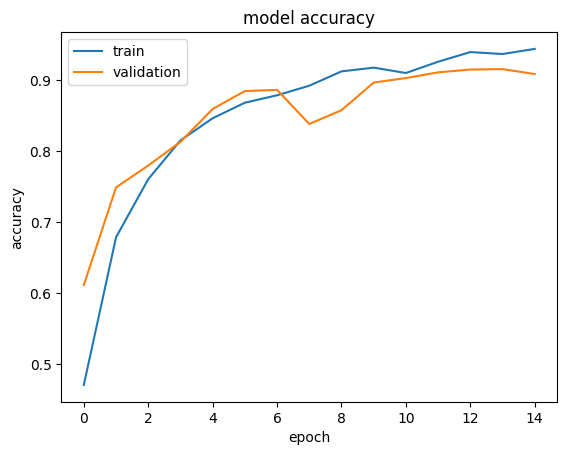

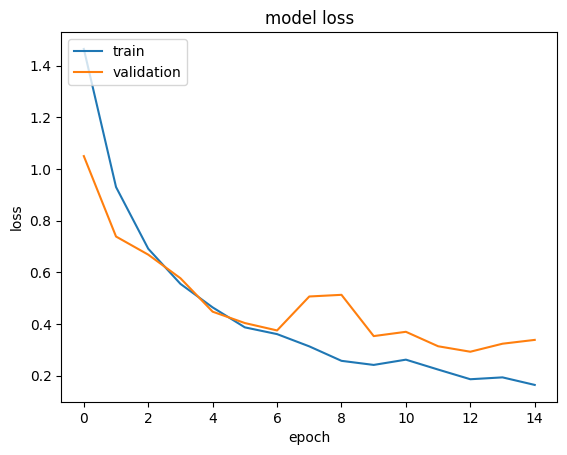

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def extract_features_rnn(file_path, n_mfcc=40):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

features = []
labels = []

for index, row in meta_data.iterrows():
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    label = row['class']
    mfccs = extract_features_rnn(file_path)
    if mfccs is not None:
        features.append(mfccs)
        labels.append(label)

features = np.array(features)
labels = np.array(labels)

X = np.array(features)
y = np.array(labels)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
#Build an RNN Model
rnn_model = Sequential([
    LSTM(128, input_shape=(features.shape[1], 1), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(one_hot_labels.shape[1], activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,778 (471.79 KB)

 Trainable params: 120,778 (471.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
#Training the RNN model

history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.2098 - loss: 2.1396 - val_accuracy: 0.3371 - val_loss: 1.7789
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3362 - loss: 1.8052 - val_accuracy: 0.4259 - val_loss: 1.5634
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4467 - loss: 1.5529 - val_accuracy: 0.5094 - val_loss: 1.3745
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5276 - loss: 1.3740 - val_accuracy: 0.5695 - val_loss: 1.2156
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5493 - loss: 1.2863 - val_accuracy: 0.5942 - val_loss: 1.1493
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6037 - loss: 1.1716 - val_accuracy: 0.6228 - val_loss: 1.1222
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6210 - loss: 1.1350 - val_accuracy: 0.6554 - val_loss: 1.0257
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6526 - loss: 1.0461 - val_accuracy

In [ ]:
test_loss, test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

55/55 - 0s - 5ms/step - accuracy: 0.8180 - loss: 0.5719
Test Accuracy: 0.82


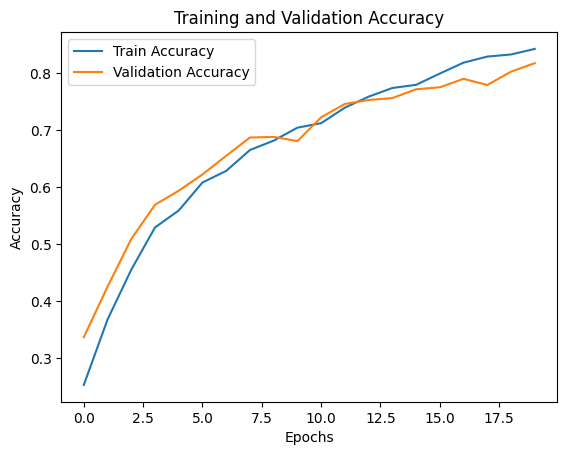

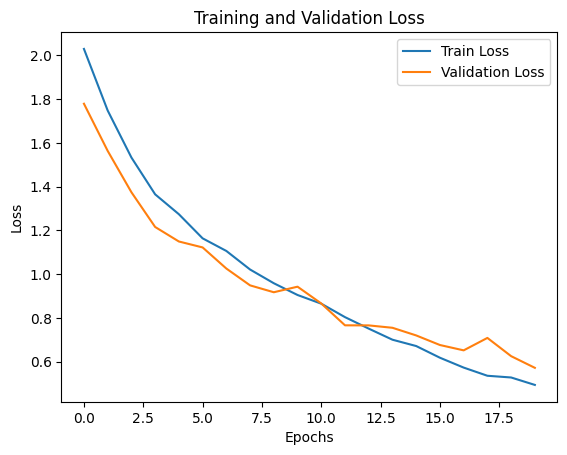

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()